In [26]:
import torch
from torch import nn, optim
from tqdm import tqdm
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

%matplotlib inline

In [27]:
LATENT_DIM = 64  # Latent space dimension
NUM_EMBEDDINGS = 128  # Number of vectors in codebook
COMMITMENT_COST = 0.25  # Beta in loss function
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3

In [28]:
# Define the transformation
transform = transforms.Compose([transforms.ToTensor()])

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=False, download=True, transform=transform),
    batch_size=64, shuffle=True
)

In [29]:
# Transforming from x -> z_e
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, latent_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # No activation, raw latents
        return x

In [30]:
# z_e -> z_q Codebook Dimension

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    
    def forward(self, x):
        B, C, H, W = x.shape  # Get input shape
        x_flattened = x.permute(0, 2, 3, 1).contiguous().view(-1, C)
        distances = torch.cdist(x_flattened, self.embedding.weight)
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices).view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        
        loss = F.mse_loss(quantized.detach(), x) + self.commitment_cost * F.mse_loss(x.detach(), quantized)
        quantized = x + (quantized - x).detach()
        
        return quantized, loss, encoding_indices

In [31]:
# z_q -> x_hat Decoding

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # Output in [0,1]
        return  x

In [32]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(embedding_dim)
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim)
    
    def forward(self, x):
        z_e = self.encoder(x)
        z_q, loss, encoding_indices = self.quantizer(z_e)
        x_hat = self.decoder(z_q)
        return x_hat, loss, encoding_indices
    
    def encode(self, x):
        return self.quantizer(self.encoder(x))[2]
    
    def decode(self, x):

        return self.decoder(x)

100%|██████████| 938/938 [01:01<00:00, 15.30it/s]


Epoch 0: Train Loss: 184.48832999914885
Test Loss: 0.36007048026658595


100%|██████████| 938/938 [01:02<00:00, 15.09it/s]


Epoch 1: Train Loss: 73.1472650617361
Test Loss: 0.28607327153440565


TypeError: Invalid shape () for image data

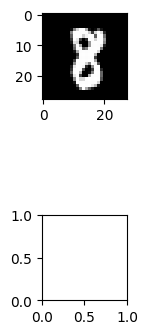

In [37]:
class Trainer:
    def __init__(self, model, optimizer, train_loader, test_loader):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_losses = []
        self.test_losses = []

    def train(self, epochs):
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for batch, _ in tqdm(self.train_loader):
                self.optimizer.zero_grad()
                x_hat, loss, _ = self.model(batch)
                loss_1 = F.binary_cross_entropy(x_hat, batch)
                loss = loss.mean()
                loss += loss_1
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.train_losses.append(train_loss)
            print(f"Epoch {epoch}: Train Loss: {train_loss}")
            self.test()
    
    def visualize_reconstructions(self, n=5
    ):
        self.model.eval()
        for batch, _ in self.test_loader:
            x_hat, _, idx = self.model(batch)
            for i in range(n):
                plt.subplot(2, n, i+1)
                plt.imshow(batch[i].squeeze().detach().numpy(), cmap="gray")
                plt.subplot(2, n, i+1+n)
                plt.imshow(idx[i].squeeze().detach().numpy(), cmap="gray")
                plt.subplot(2, n, i+1+n)
                plt.imshow(x_hat[i].squeeze().detach().numpy(), cmap="gray")
            plt.show()
            break

    def test(self):
        self.model.eval()
        test_loss = 0
        for batch, _ in self.test_loader:
            x_hat, loss, _ = self.model(batch)
            loss = loss.mean()
            test_loss += loss.item()
        self.test_losses.append(test_loss)
        print(f"Test Loss: {test_loss}")

model = VQVAE(NUM_EMBEDDINGS, LATENT_DIM, COMMITMENT_COST)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer = Trainer(model, optimizer, train_loader, test_loader)
trainer.train(2)
trainer.visualize_reconstructions()
trainer.test()